In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
# import cv2
import matplotlib.pyplot as plt

In [2]:
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling='avg')

outputs_dict = dict([(layer.name, layer.output) for layer in vgg_model.layers])

feature_extractor = Model(inputs=vgg_model.inputs, outputs=outputs_dict)

In [3]:
def load_image(path, preprocess=False):
    
    img = image.load_img(path, target_size=(224, 224))
    img = image.img_to_array(img)
    if preprocess:
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        
    img = tf.convert_to_tensor(img)
    
    return img

def deprocess_image(x, height, width):
    """Convert a tensor into a valid image"""
    x = x.reshape((height, width, 3))
    # Remove zero-center by mean pixel applied by vgg19.preprocess_input()
    # The following values are the mean pixel values of each color channel for the ImageNet dataset
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [4]:
def content_loss(original, combine):
    squared_difference = tf.square(original - combine)
    
    return tf.reduce_sum(squared_difference)

def gram_matrix(feature_map, normalize=True):
    batch, height, width, depth = feature_map.shape

    feature_map = tf.reshape(feature_map, (depth, height * width))
    gram_matrix = tf.matmul(feature_map, tf.transpose(feature_map))
    
    if normalize:
        gram_matrix /= height * width * depth
    
    return gram_matrix

def style_loss(style, combination):
    
    batch, width, height, filters = style.shape
    
    g_style = gram_matrix(style)
    g_combination = gram_matrix(combination)

    layer_loss = tf.square(g_style - g_combination)

    return (1 / (4 * (int(width) * int(height)) * int(filters)**2) * tf.reduce_sum(layer_loss))

In [9]:
content_image = load_image('./styles/kitten.jpg', preprocess=True)
style_image = load_image('./styles/starry_night.jpg', preprocess=True)

In [10]:
mean = 0
var = 10
sigma = var ** 0.5

combination = np.random.uniform(0, 255, (content_image.shape[1:])).astype(np.float32)
# combination = np.random.normal(mean, sigma, (content_image.shape[1:])).astype(np.float32)

combination = preprocess_input(combination)
combination = tf.convert_to_tensor(combination)


combination_image = tf.Variable(np.expand_dims(combination, axis=0))

# combination_image = tf.Variable(content_image)


In [11]:
total_variation_weight = 1e-6

@tf.function
def step(combination_image, content_image, content_layer, style_layers):
    
    with tf.GradientTape() as tape:
        
        combination_feature = feature_extractor(combination_image)
        content_feature = feature_extractor(content_image)[content_layer]
        style_feature = {layer: feature_extractor(style_image)[layer] for layer in style_layers}
        
        loss = tf.zeros(shape=())

        c_loss = content_loss(combination_feature[content_layer], content_feature)
        
        s_loss = sum([(1/len(style_layers)) * style_loss(style_feature[layer], combination_feature[layer]) for layer in style_layers])
        
        loss = 10e-6 * c_loss + s_loss

    grads = tape.gradient(loss, combination_image)
    
    return loss, grads

Epoch [0/4000], loss: 269104.78


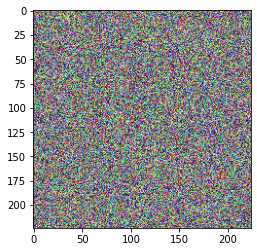

Epoch [10/4000], loss: 191781.02


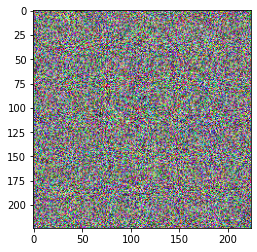

Epoch [20/4000], loss: 161767.92


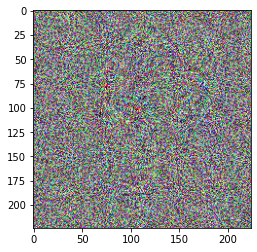

Epoch [30/4000], loss: 138135.48


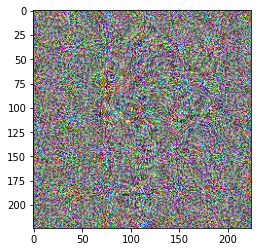

Epoch [40/4000], loss: 118876.72


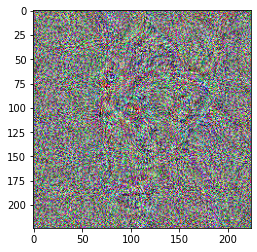

Epoch [50/4000], loss: 103095.60


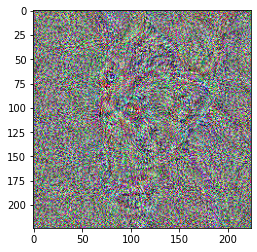

Epoch [60/4000], loss: 90220.70


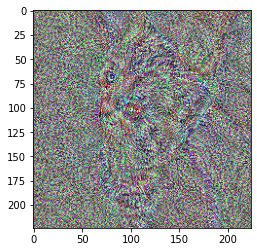

Epoch [70/4000], loss: 79604.34


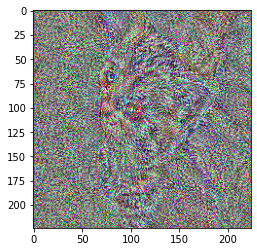

Epoch [80/4000], loss: 70385.63


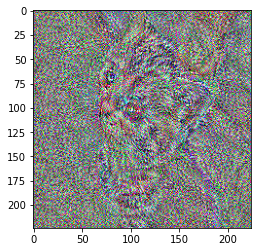

Epoch [90/4000], loss: 62504.82


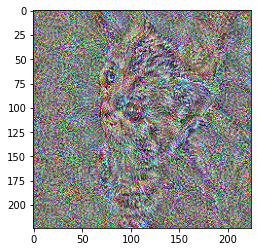

Epoch [100/4000], loss: 55745.73


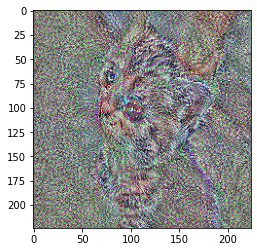

Epoch [110/4000], loss: 50006.14


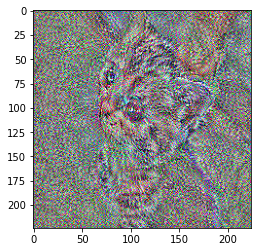

Epoch [120/4000], loss: 45198.89


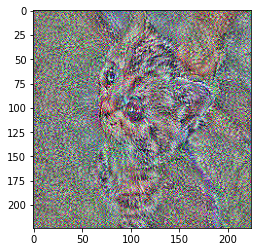

Epoch [130/4000], loss: 41138.48


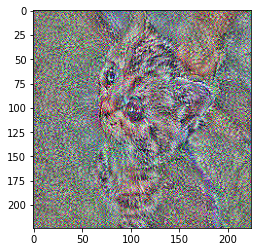

Epoch [140/4000], loss: 37692.96


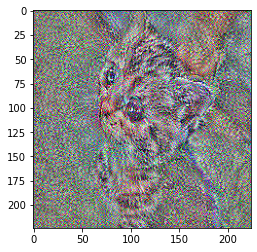

Epoch [150/4000], loss: 34718.08


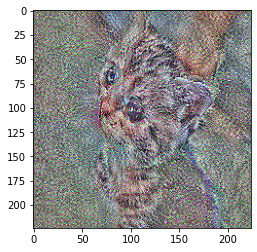

Epoch [160/4000], loss: 32112.27


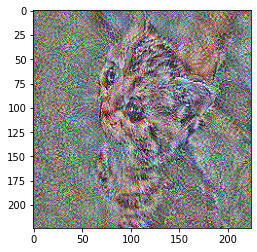

Epoch [170/4000], loss: 29834.92


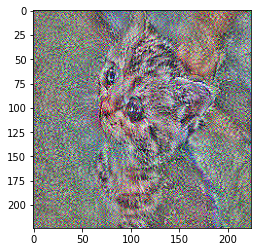

Epoch [180/4000], loss: 27870.56


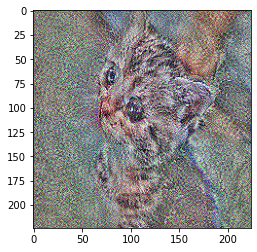

Epoch [190/4000], loss: 26174.25


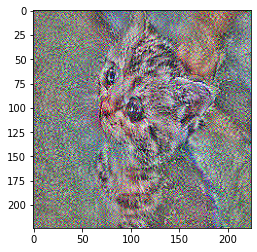

Epoch [200/4000], loss: 24657.23


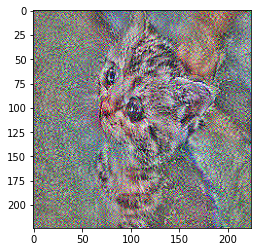

Epoch [210/4000], loss: 23308.47


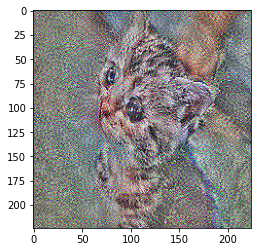

Epoch [220/4000], loss: 22116.82


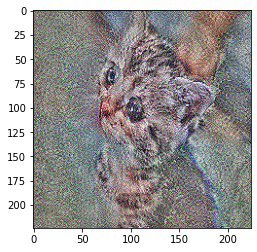

Epoch [230/4000], loss: 21051.33


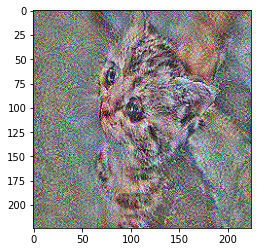

Epoch [240/4000], loss: 20091.72


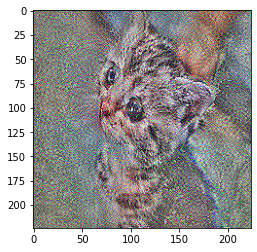

Epoch [250/4000], loss: 19228.90


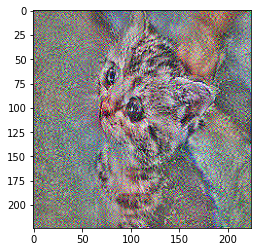

Epoch [260/4000], loss: 18450.04


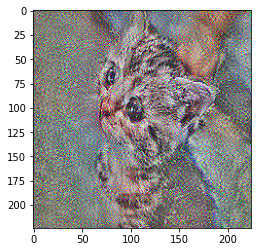

Epoch [270/4000], loss: 17727.67


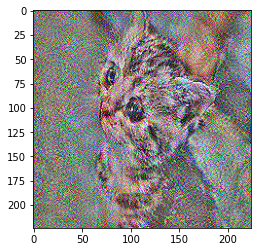

Epoch [280/4000], loss: 17052.19


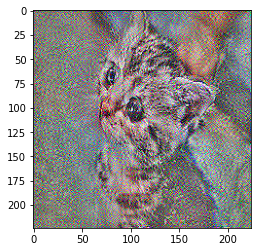

Epoch [290/4000], loss: 16422.80


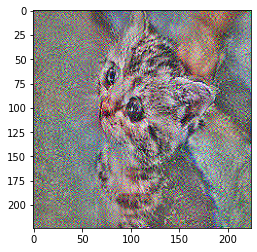

Epoch [300/4000], loss: 15830.64


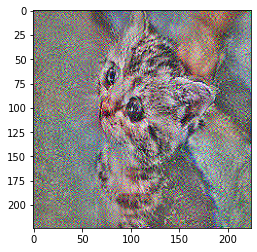

Epoch [310/4000], loss: 15283.99


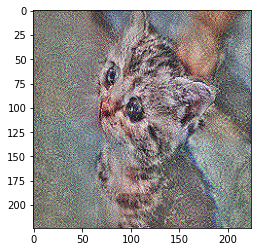

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay, CosineDecay
import sys
import time

content_layer = "block4_conv2"
style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
n_epochs = 4000
lr = 1

opt = Adam(learning_rate=lr)
# opt = SGD(learning_rate=ExponentialDecay(initial_learning_rate=100, decay_steps=100, decay_rate=0.96))


# opt = SGD(
#     ExponentialDecay(
#         initial_learning_rate=100, decay_steps=100, decay_rate=0.96
#     )
# )

for epoch in range(0, n_epochs + 1):

    loss, grads = step(combination_image, content_image, content_layer, style_layers)
    opt.apply_gradients([(grads, combination_image)])
    
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{n_epochs}], loss: {loss:.2f}")
        plt.imshow(deprocess_image(combination_image.numpy(), 224, 224))
        plt.show()

In [ ]:
final_image = deprocess_image(combination_image.numpy(), 224, 224)

In [ ]:
fig, axs = plt.subplots(1, 2,  figsize=(15, 15))
axs[0].imshow(final_image)
axs[1].imshow(combination.astype(np.uint8))
plt.show()